# Assignment 03_: ResNet50 


### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import f1_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

import torchvision
import torchvision.transforms as transforms
import torch




/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True


### Dataset


#### mnist

In [4]:

mnist_mean = (0.1307,)
mnist_std = (0.3081,)


transform_mnist_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomCrop(28, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])

transform_mnist_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])


train_set = torchvision.datasets.MNIST(root='../data', train=True,
                                       download=True, transform=transform_mnist_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)


test_set = torchvision.datasets.MNIST(root='../data', train=False,
                                      download=True, transform=transform_mnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=2)


class_names = [str(i) for i in range(10)]


### Model

In [5]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    


def resnet50(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

model = resnet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

### Optimizer

In [6]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [7]:
##################### Write your answer here ##################
# Define the loss function

criterion =  nn.CrossEntropyLoss()
###############################################################

In [8]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    # Calculate the loss
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [9]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [10]:
training_loss = []
training_acc = []
training_f1=[]
testing_loss = []
testing_acc = []
testing_f1=[]


train_preds = []
train_targets = []
test_preds = []
test_targets = []

start_time=time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    
    train_preds.extend(preds.cpu().numpy())
    train_targets.extend(target.cpu().numpy())
    training_f1.append(f1_score(train_targets, train_preds, average='weighted'))
    
  

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(target.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        testing_f1.append(f1_score(test_targets, test_preds, average='weighted'))

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

            
end_time = time.time()
training_time = end_time - start_time
         

print(f"Training time: {training_time} seconds")

Epoch: 1/30 Train Loss: 0.0136 Acc: 0.5152
Begin test......
Test Loss: 0.0053 Acc: 0.7786
Epoch: 2/30 Train Loss: 0.0027 Acc: 0.8933
Begin test......
Test Loss: 0.0014 Acc: 0.9416
Epoch: 3/30 Train Loss: 0.0016 Acc: 0.9376
Begin test......
Test Loss: 0.0011 Acc: 0.9576
Epoch: 4/30 Train Loss: 0.0016 Acc: 0.9395
Begin test......
Test Loss: 0.0008 Acc: 0.9678
Epoch: 5/30 Train Loss: 0.0010 Acc: 0.9602
Begin test......
Test Loss: 0.0008 Acc: 0.9651
Epoch: 6/30 Train Loss: 0.0013 Acc: 0.9508
Begin test......
Test Loss: 0.0007 Acc: 0.9701
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.9680
Begin test......
Test Loss: 0.0005 Acc: 0.9784
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.9718
Begin test......
Test Loss: 0.0006 Acc: 0.9722
Epoch: 9/30 Train Loss: 0.0006 Acc: 0.9743
Begin test......
Test Loss: 0.0004 Acc: 0.9813
Epoch: 10/30 Train Loss: 0.0006 Acc: 0.9756
Begin test......
Test Loss: 0.0004 Acc: 0.9841
Epoch: 11/30 Train Loss: 0.0005 Acc: 0.9797
Begin test......
Test Loss: 0.0004 Acc: 0.9820
Epoch: 1

### Model Analysis


In [11]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    
    image_features = model.forward(image)
    

    image_features /= image_features.norm(dim=-1, keepdim=True)
    

    logits =  image_features

    ###############################################################

    return logits

In [13]:
from sklearn.metrics import confusion_matrix, classification_report


y_true = []
y_pred = []

with torch.no_grad():
    model.eval()

    for batch_idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)
        target = target.to(device)

        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)

        y_true += target.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_names)


print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

class_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)

Confusion Matrix:
[[ 977    0    0    0    0    1    1    1    0    0]
 [   0 1128    1    3    0    0    2    1    0    0]
 [   2    0  999    0    0   19    8    4    0    0]
 [   0    0    2 1001    0    5    0    1    1    0]
 [   0    0    0    0  975    0    1    2    1    3]
 [   1    1   10    5    0  871    2    1    0    1]
 [   3    1    6    0    0    1  946    0    1    0]
 [   0    2    3    1    2    5    0 1014    0    1]
 [   0    0    1    5    0    2    0    0  964    2]
 [   0    0    2    3    7    1    0    3    8  985]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.96      0.98      0.97       892
           6       0.99      0.99      0.99     

In [14]:
# 在模型评估部分添加以下代码
testing_loss = []

with torch.no_grad():
    model.eval()

    for batch_idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)
        target = target.to(device)

        logits = model_inference(model, image)

        # 计算交叉熵损失
        loss = F.cross_entropy(logits, target)
        testing_loss.append(loss.item())

average_loss = np.mean(testing_loss)
print(f"Average Loss on Test Set: {average_loss}")

Average Loss on Test Set: 6.364908200276049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


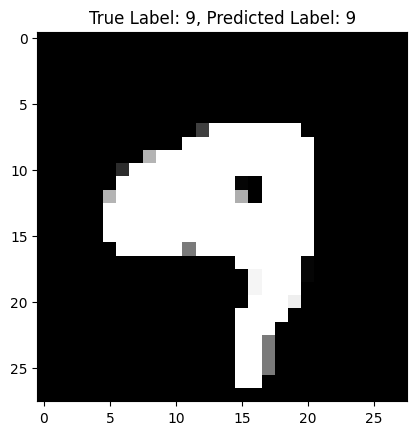

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


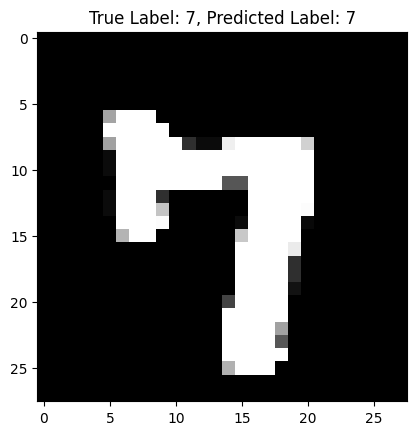

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


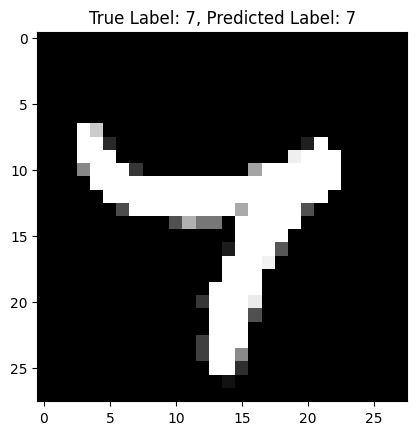

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


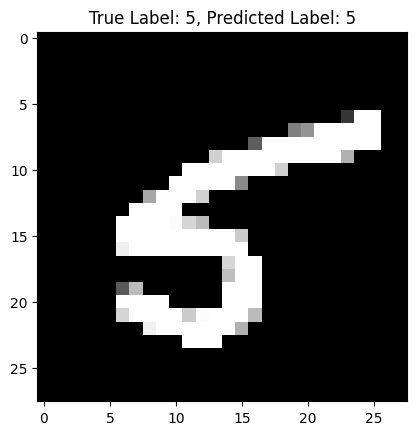

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


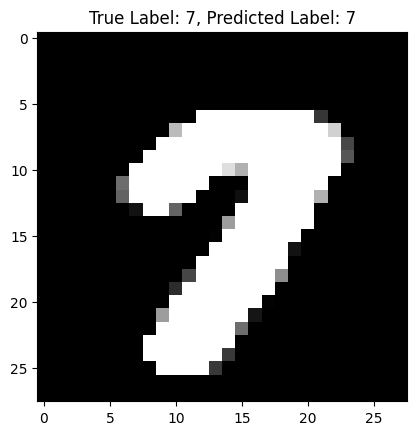

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

model.eval()

num_visualizations = 5 

for _ in range(num_visualizations):
    idx = random.randint(0, len(test_set)-1)
    image, target = test_set[idx]

    image_tensor = image.unsqueeze(0).to(device)

    logits = model_inference(model, image_tensor)
    _, pred = torch.max(logits, 1)

    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.title(f"True Label: {class_names[target]}, Predicted Label: {class_names[pred.item()]}")

    # 保存图像
    plt.savefig(f'visualization_2{_+1}.png')  # 保存为不同的文件名

    plt.show()
